In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')

In [3]:
len(df)

11914

In [4]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [6]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


<AxesSubplot:xlabel='msrp', ylabel='Count'>

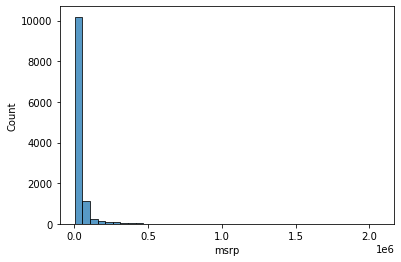

In [7]:
sns.histplot(df.msrp, bins=40)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

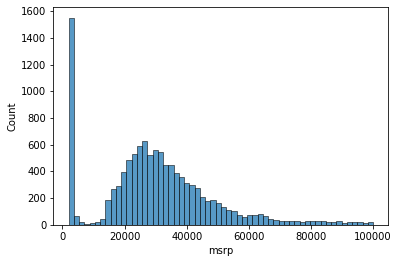

In [8]:
sns.histplot(df.msrp[df.msrp < 100000])

In [9]:
log_price = np.log1p(df.msrp)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

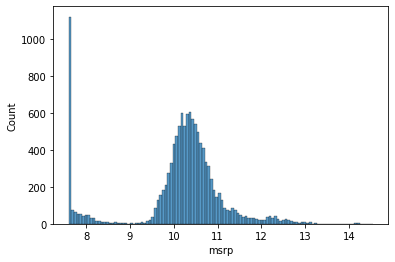

In [10]:
sns.histplot(log_price)

In [11]:
## Splitting Data into validation, test and training sets
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [12]:
## Initial analysis showed a long tail in the distribution of prices, and to remove its effect, we need to apply the log transformation
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

## To avoid accidentally using the target variable later, let's remove it from the dataframes
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

In [13]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]

In [14]:
df_num = df_num.fillna(0) # let's filling the missing values with zeros

X_train = df_num.values # convert this DataFrame to a NumPy array

In [15]:
# Linear Regresion WIth NumPy
def train_linear_regression(X,y):
    # Adding the dummy column
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X]) #Adds the array of 1's as the first column of X
    
    # Normal Equation Formula
    XTX = X.T.dot(X) # Computes X^TX
    XTX_inv = np.linalg.inv(XTX) # Computes the inverse of X^TX
    w = XTX_inv.dot(X.T).dot(y) # Computes the rest of the normal equation
    
    return w[0], w[1:] # Splits the weights vector into the bias and the rest of weights

In [16]:
w_0, w = train_linear_regression(X_train, y_train) # We have just trained the first model ! 

In [17]:
y_pred = w_0 + X_train.dot(w) # Now we can apply it to the training data to see how well it predicts

To see how good the predictions are, we can use histplot to plot the predicted values and compare them with the actual prices:

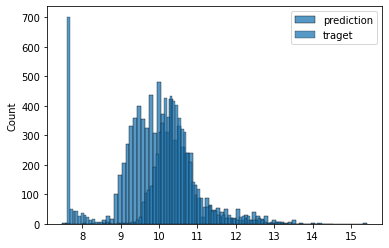

In [18]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='traget')
plt.legend()

But we need to use a metric that quantifies the quality of the model.  
We can use many metrics to evaluate how we a regression model behaves.  
The most commonly used one is _root mean squared error_ RMSE for short  

RMSE tells us how large the errors ares that our model makes. It's computed with the following formula:  
RMSE = $\sqrt{ \frac{1}{m} \sum_{i=1}^m (g(x_i) - y_i)^2} $

In [19]:
# Implementation of RMSE
def rmse(y, y_pred):
    error = y_pred - y # difference between the prediction and the target 
    mse = (error ** 2).mean() #Compures MSE, first the sqared error, and then its mean
    return np.sqrt(mse) # takes the square root to get RMSE

In [20]:
rmse(y_train, y_pred)

0.7554192603920133

This number tells us that on average, the modelś predictions are off by 0.75. If one model has a better(lower) RMSE thant the other, it indicates that model is better

In [21]:
# LEt's create a X_VAL matrix
df_num = df_val[base]
df_num = df_num.fillna(0)
X_val = df_num.values

In [22]:
y_pred = w_0 + X_val.dot(w)

Now we use y_pred and compare it with the actual prices from y-val, using the RMSE function

In [23]:
rmse(y_val, y_pred)

0.7616530991301607

Training and validations test require the same preprocessing, and we wrote the same code twice. Thus it makes sense to move this logic to a separate function an avoid duplicating the code

In [24]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [25]:
# Now training and evaluation becomes simpler, and looks like this:
X_train = prepare_X(df_train) # trains the model
w_0, w = train_linear_regression(X_train, y_train) 

X_val = prepare_X(df_val) # Applies the model to the validation dataset
y_pred = w_0 + X_val.dot(w)
print('validation: ', rmse(y_val, y_pred)) # Computes RMSE on the validation data

validation:  0.7616530991301607
